In [18]:
import os,bs4
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from langchain_openai import AzureChatOpenAI,AzureOpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.chroma import Chroma
from typing import  TypedDict,Literal,Annotated,Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langchain import hub
from pydantic import BaseModel,Field
from langgraph.graph import StateGraph,START,END,MessagesState
from langchain.tools import tool
from langgraph.types import Command

In [ ]:
load_dotenv()
token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
az_chat_model= AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    model= "gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

embedding_model= AzureOpenAIEmbeddings(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    model= "text-embedding-ada-002"
)

-  We have different patterns for building Multi agents

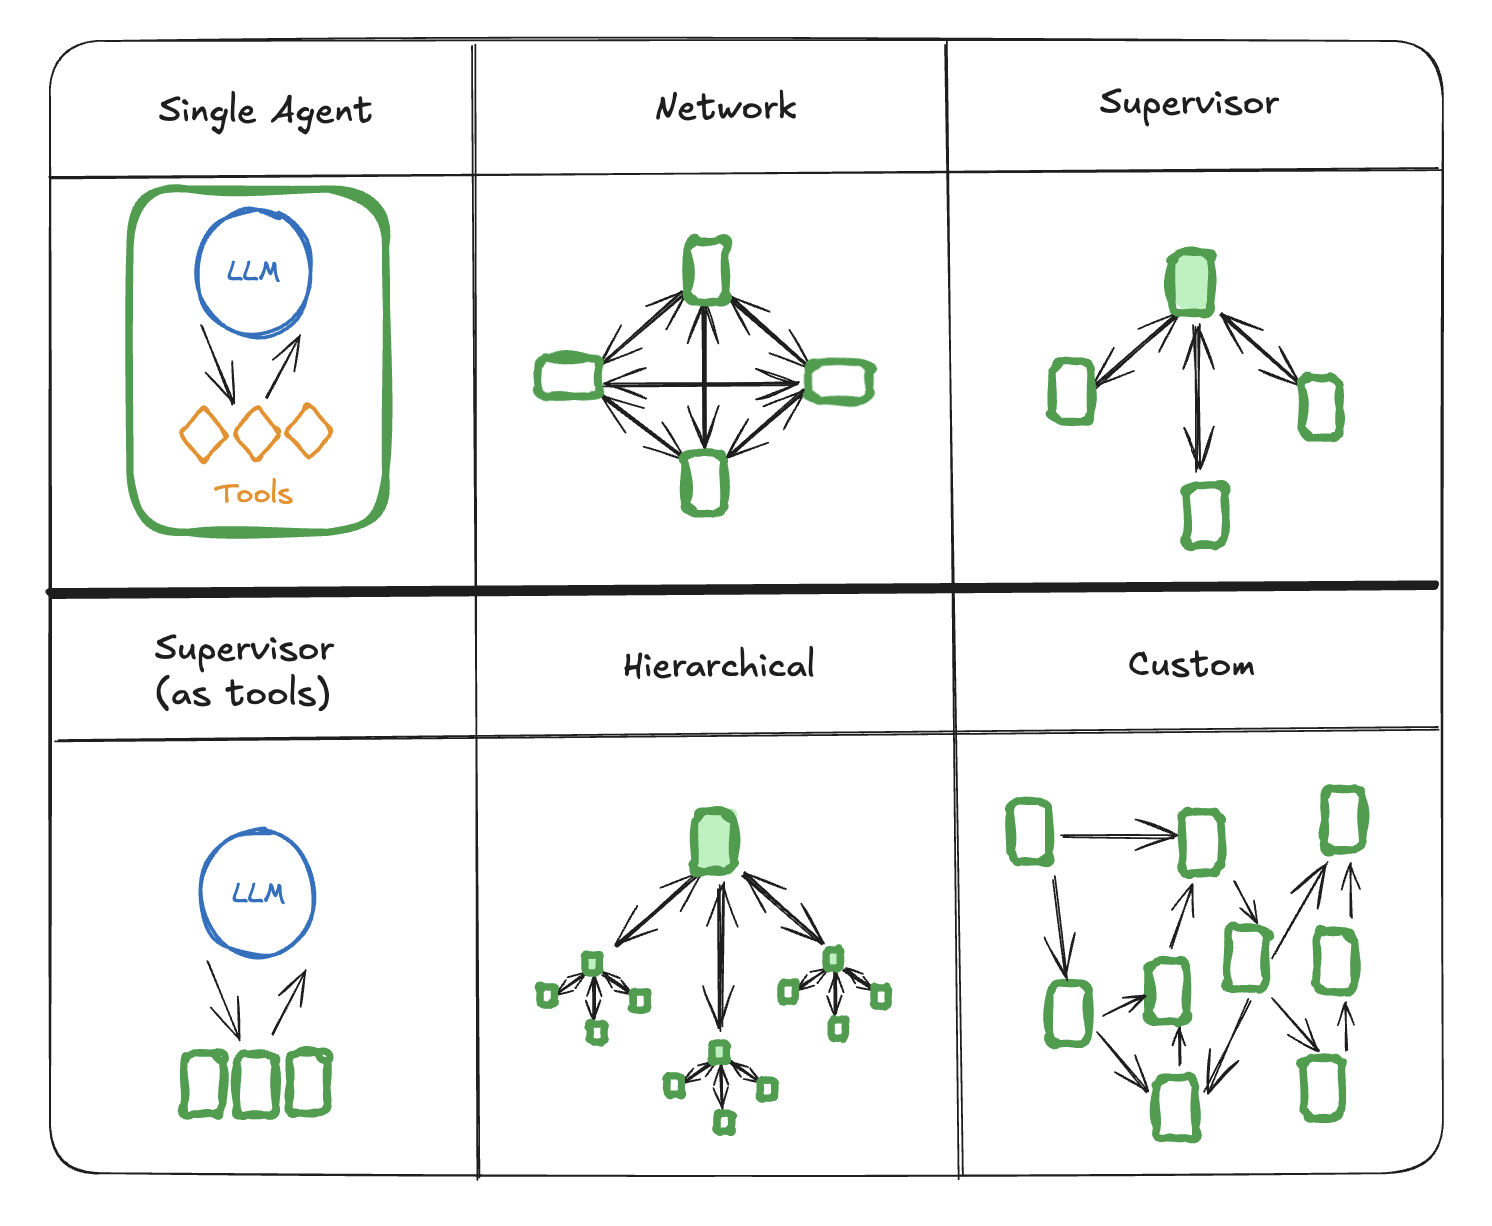

There are several ways to connect agents in a multi-agent system:

- Network: each agent can communicate with every other agent. Any agent can decide which other agent to call next.
- Supervisor: each agent communicates with a single supervisor agent. Supervisor agent makes decisions on which agent should be called next.
- Supervisor (tool-calling): this is a special case of supervisor architecture. Individual agents can be represented as tools. In this case, a supervisor agent uses a tool-calling LLM to decide which of the agent tools to call, as well as the arguments to pass to those agents.
- Hierarchical: you can define a multi-agent system with a supervisor of supervisors. This is a generalization of the supervisor architecture and allows for more complex control flows.
- Custom multi-agent workflow: each agent communicates with only a subset of agents. Parts of the flow are deterministic, and only some agents can decide which other agents to call next.

In [ ]:
@tool
def add(state):
    """Dummy Add opeartion"""
    sum=state["num1"]+state["num2"]
    return Command(goto="multiply",update=[sum])

In [ ]:
add.invoke({"num1":2,"num2":4})

In [12]:
@tool
def transfer_to_multiplication_expert():
    """This will ask multiply agent to hlep"""
    return

In [11]:
@tool
def transfer_to_additon_expert():
    """This will ask addition agent to hlep"""
    return

In [17]:
llm_with_model = az_chat_model.bind_tools([transfer_to_additon_expert,transfer_to_multiplication_expert])
response = llm_with_model.invoke("Multiply 2  with 4 ")
print(response.tool_calls)

[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_jIB6R9AwTE4Y3jCQ8ExTJhOh', 'type': 'tool_call'}]


In [19]:
def additional_expert(state: MessagesState) -> Command[Literal["multiplication_agent","__end__"]] :
    pass

In [20]:
def multiplication_agent(state: MessagesState) -> Command[Literal["additional_expert","__end__"]] :
    pass

In [22]:
graph= StateGraph(MessagesState)
graph.add_node("additional_agent",additional_expert)
graph.add_node("multiply_agent",multiplication_agent)


graph.add_edge(START,"additional_agent")
graph.compile()
90

ValueError: Found edge ending at unknown node `multiplication_agent`